In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
import sys
import cobra

In [2]:
# Generate complete dataset
genome_ids = glob.glob('../metabolic_output/*.data')
genome_ids = [x.replace("../metabolic_output/","").replace(".data","") for x in genome_ids]

ID_list = []
# Write header to file
for carb_ind in list(range(0,32)):
    for prod_ind in list(range(0,35)):
        ID = str(str(carb_ind) + '.0.' + str(prod_ind))
        ID_list.append(ID)

output_file = '../Data/whole_path_avg.tsv'        

output_file = open(output_file, 'w')
header = 'genomes\t' + '\t'.join(ID_list) + '\n'
output_file.write(header)

for genome_id in genome_ids:
    file_name = "../metabolic_output/%s.data" % (genome_id)
    total_dataset_dict = pickle.load(open(file_name, "rb"))
    # Write row name
    output_file.write(genome_id + '\t')
    # Write whole_path_like to rows
    for carb_ind in list(range(0,32)):
        for prod_ind in list(range(0,35)):
            ID = str(genome_id + ':' + str(carb_ind) + '.0.' + str(prod_ind))
            if ID != str(genome_id + ':31.0.34'):
                output_file.write(str(round(total_dataset_dict[ID]['whole_path_like'],4))+'\t')
            elif ID == str(genome_id + ':31.0.34'):
                output_file.write(str(round(total_dataset_dict[ID]['whole_path_like'],4))+'\n')
            else:
                print('ERROR')
output_file.close()

In [9]:
# Generate 'robust' dataset
genome_ids = glob.glob('../metabolic_output/*.data')
genome_ids = [x.replace("../metabolic_output/","").replace(".data","") for x in genome_ids]

ID_list = []
# Write header to file
for prod_ind in list(range(0,35)):
    ID = str(str(prod_ind))
    ID_list.append(ID)

output_file = '../Data/whole_path_avg_robust.tsv'  

output_file = open(output_file, 'w')
header = 'genomes\t' + '\t'.join(ID_list) + '\n'
output_file.write(header)

for genome_id in genome_ids:
    file_name = "../metabolic_output/%s.data" % (genome_id)
    total_dataset_dict = pickle.load(open(file_name, "rb"))
    # Write row name
    output_file.write(genome_id + '\t')
    # Write whole_path_like to rows
    
    for prod_ind in list(range(0,35)):
        robust_output =[]
        for carb_ind in list(range(0,32)):
            ID = str(genome_id + ':' + str(carb_ind) + '.0.' + str(prod_ind))
            if ID != str(genome_id + ':16.0.25'):
                robust_output.append(round(total_dataset_dict[ID]['whole_path_like'],4))
        robust_avg = np.median(robust_output) # Median rather than mean
        if prod_ind != 34:
            output_file.write(str(round(robust_avg,4))+'\t')
        elif prod_ind == 34:
            output_file.write(str(round(robust_avg,4))+'\n')
        else:
            print('ERROR')

output_file.close()

In [7]:
# Test distributions of genome mean likelihood
t = time.time()

sys.stdout.write('Loading in model...')

universal = cobra.io.load_json_model("../Data/GramPosUni.json")
genome_id = '220668.9'
model = cobra.io.read_sbml_model('../gap_models/'+ genome_id +'.xml')
likelihoods = pickle.load(open('../likelihoods/'+ genome_id +'.probs'))

sys.stdout.write('Adding Water...')

# Ensure free diffusion of water
model.reactions.get_by_id('rxn05319_c').name = "Water transport"
model.reactions.get_by_id('rxn05319_c').bounds = (-1000., 1000.)

### Set Up Model: remove low likelihood reactions
sys.stdout.write('Set-up Model...')
low_like_model = []
for rxn in model.reactions:
    if rxn.id.startswith('rxn'):
        try:
            if likelihoods[rxn.id] <= 0.1:
                low_like_model.append(rxn.id)
        except:
            pass
model_rxns_to_remove = [model.reactions.get_by_id(rxn) for rxn in low_like_model]
model.remove_reactions(model_rxns_to_remove)

model_rxn_likes = []
for rxn in model.reactions:
    try:
        model_rxn_likes.append(likelihoods[rxn.id])
    except:
        pass

print(str(round(time.time() - t)) + 'seconds to complete')

Loading in model...Adding Water...Set-up Model...19.0seconds to complete


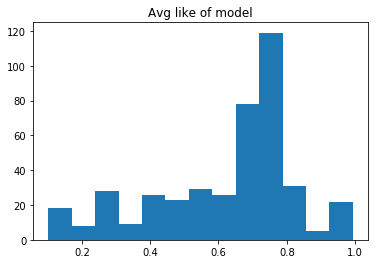

In [8]:
plt.hist(model_rxn_likes, bins='auto')  #
plt.title("Avg like of model")
plt.show()

In [9]:
np.mean(model_rxn_likes)

0.6186849113569748

In [10]:
np.median(model_rxn_likes)

0.672922094188033

In [13]:
# Create TSV for mean/median genome likelihood values
t = time.time()

genome_ids = glob.glob('../metabolic_output/*.data')
genome_ids = [x.replace("../metabolic_output/","").replace(".data","") for x in genome_ids]

# sys.stdout.write('Loading in model...')

output_file = '../Data/genome_likelihoods.tsv'  

output_file = open(output_file, 'w')
header = 'genomes\t' + 'mean\t' + 'median\n'
output_file.write(header)

for genome_id in genome_ids:
    model = cobra.io.read_sbml_model('../gap_models/'+ genome_id +'.xml')
    likelihoods = pickle.load(open('../likelihoods/'+ genome_id +'.probs'))
    model.reactions.get_by_id('rxn05319_c').name = "Water transport"
    model.reactions.get_by_id('rxn05319_c').bounds = (-1000., 1000.)
    ### Set Up Model: remove low likelihood reactions
    low_like_model = []
    for rxn in model.reactions:
        if rxn.id.startswith('rxn'):
            try:
                if likelihoods[rxn.id] <= 0.1:
                    low_like_model.append(rxn.id)
            except:
                pass
    model_rxns_to_remove = [model.reactions.get_by_id(rxn) for rxn in low_like_model]
    model.remove_reactions(model_rxns_to_remove)
    # Generate list of likelihoods for all reactions in model
    model_rxn_likes = []
    for rxn in model.reactions:
        try:
            model_rxn_likes.append(likelihoods[rxn.id])
        except:
            pass
    # Write info to tsv file
    output_file.write(genome_id + '\t')
    output_file.write(str(np.mean(model_rxn_likes)) + '\t')
    output_file.write(str(np.median(model_rxn_likes)) + '\n')

print(str(round(time.time() - t)) + 'seconds to complete')

428.0seconds to complete


In [3]:
# Create TSV for genome size
t = time.time()

genome_ids = glob.glob('../metabolic_output/*.data')
genome_ids = [x.replace("../metabolic_output/","").replace(".data","") for x in genome_ids]

# sys.stdout.write('Loading in model...')

output_file = '../Data/genome_sizes.tsv'  

output_file = open(output_file, 'w')
header = 'genomes\t' + 'mean\t' + 'median\n'
output_file.write(header)

for genome_id in genome_ids:
    model = cobra.io.read_sbml_model('../gap_models/'+ genome_id +'.xml')
    likelihoods = pickle.load(open('../likelihoods/'+ genome_id +'.probs'))
    model.reactions.get_by_id('rxn05319_c').name = "Water transport"
    model.reactions.get_by_id('rxn05319_c').bounds = (-1000., 1000.)
    ### Set Up Model: remove low likelihood reactions
    low_like_model = []
    for rxn in model.reactions:
        if rxn.id.startswith('rxn'):
            try:
                if likelihoods[rxn.id] <= 0.1:
                    low_like_model.append(rxn.id)
            except:
                pass
    model_rxns_to_remove = [model.reactions.get_by_id(rxn) for rxn in low_like_model]
    model.remove_reactions(model_rxns_to_remove)

    # Write info to tsv file
    output_file.write(genome_id + '\t')
    output_file.write(str(len(model.reactions)) + '\t')
    output_file.write('PH\n')

print(str(round(time.time() - t)) + 'seconds to complete')

434.0seconds to complete


In [3]:
# Amino Acid related metabolites
products = [
    ['D-Alanine','cpd00117'], #EXs : 
    ['D-Glutamate','cpd00186'], #EXs : 
    ['D-Methionine','cpd00637'], #EXs : 
    ['D-Serine','cpd00550'], #EXs : 
    ['Glycine','cpd00033'], #EXs : 1
    ['L-Alanine','cpd00035'], #EXs : 2
    ['L-Arginine','cpd00051'], #EXs : 3
    ['L-Asparagine','cpd00132'], #EXs : 4
    ['L-Aspartate','cpd00041'], #EXs : 5
    ['L-Cysteine','cpd00084'], #EXs : 7
    ['L-Glutamate','cpd00023'], #EXs : 8
    ['L-Glutamine','cpd00053'], #EXs : 9
    ['L-Histidine','cpd00119'], #EXs : 10
    ['L-Isoleucine','cpd00322'], #EXs : 11
    ['L-Leucine','cpd00107'], #EXs : 12
    ['L-Lysine','cpd00039'], #EXs : 13
    ['L-Methionine','cpd00060'], #EXs : 14
    ['L-Phenylalanine','cpd00066'], #EXs : 15
    ['L-Proline','cpd00129'], #EXs : 16
    ['L-Serine','cpd00054'], #EXs : 17
    ['L-Threonine','cpd00161'], #EXs : 18
    ['L-Tryptophan','cpd00065'], #EXs : 19
    ['L-Tyrosine','cpd00069'], #EXs : 20
    ['L-Valine','cpd00156'], #EXs : 21
    ['H2O2','cpd00025'],
    ['L-Lactate','cpd00159'],
#     ['Acetate','cpd00029'],
    ['Butyrate','cpd00211'],
#     ['isobutyrate','cpd01711'], 
    ['GABA','cpd00281'],
    ['ethanol','cpd00363'],
    ['Propionate','cpd00141'],
    ['formate','cpd00047'],
#     ['Valerate','cpd00597'],
#     ['Isovaleric acid','cpd05178'], # Not in universal?
    ['TMAO','cpd00811'], # (CH3)3NO
#     ['Indole-3-(carb)aldehyde','cpd05401'],
#     ['Acetaldehyde','cpd00071'],
    ['Deoxycholate','cpd02733'],
    ['Chorismate','cpd00216'],
    ['Hexanoate','cpd01113']
]

In [7]:
for i in products:
    print("'"+i[0]+"',")

'D-Alanine',
'D-Glutamate',
'D-Methionine',
'D-Serine',
'Glycine',
'L-Alanine',
'L-Arginine',
'L-Asparagine',
'L-Aspartate',
'L-Cysteine',
'L-Glutamate',
'L-Glutamine',
'L-Histidine',
'L-Isoleucine',
'L-Leucine',
'L-Lysine',
'L-Methionine',
'L-Phenylalanine',
'L-Proline',
'L-Serine',
'L-Threonine',
'L-Tryptophan',
'L-Tyrosine',
'L-Valine',
'H2O2',
'L-Lactate',
'Butyrate',
'GABA',
'ethanol',
'Propionate',
'formate',
'TMAO',
'Deoxycholate',
'Chorismate',
'Hexanoate',


In [5]:
print(products[18])
print(products[29])
print(products[7])
print(products[12])
print(products[30])

['L-Proline', 'cpd00129']
['Propionate', 'cpd00141']
['L-Asparagine', 'cpd00132']
['L-Histidine', 'cpd00119']
['formate', 'cpd00047']


In [11]:
print(products[24])
print(products[15])
print(products[10])
print(products[8])
print(products[6])
print(products[1])

['H2O2', 'cpd00025']
['L-Lysine', 'cpd00039']
['L-Glutamate', 'cpd00023']
['L-Aspartate', 'cpd00041']
['L-Arginine', 'cpd00051']
['D-Glutamate', 'cpd00186']


In [12]:
print(products[7])
print(products[9])
print(products[12])
print(products[18])
print(products[28])
print(products[29])

['L-Asparagine', 'cpd00132']
['L-Cysteine', 'cpd00084']
['L-Histidine', 'cpd00119']
['L-Proline', 'cpd00129']
['ethanol', 'cpd00363']
['Propionate', 'cpd00141']


In [3]:
genome_ids = glob.glob('../metabolic_output/*.data')
genome_ids = [x.replace("../metabolic_output/","").replace(".data","") for x in genome_ids]

for genome_id in genome_ids:
    file_name = "../metabolic_output/%s.data" % (genome_id)
    total_dataset_dict = pickle.load(open(file_name, "rb"))
    for carb_ind in list(range(0,32)):
        for prod_ind in list(range(0,35)):
            ID = str(genome_id + ':' + str(carb_ind) + '.0.' + str(prod_ind))
            if np.isnan(round(total_dataset_dict[ID]['whole_path_like'],4)):
                print(ID)

1002365.5:16.0.25
1203258.5:16.0.25
1203259.4:16.0.25
1256196.3:16.0.25
1256205.3:16.0.25
1256209.3:16.0.25
1256210.3:16.0.25
1256219.3:16.0.25
1256224.3:16.0.25
1263085.3:16.0.25
1293598.4:16.0.25
1300223.3:16.0.25
1318629.3:16.0.25
1380361.3:16.0.25
1390383.3:16.0.25
1390384.3:16.0.25
1390386.3:16.0.25
1402207.4:16.0.25
1408180.3:16.0.25
1408205.4:16.0.25
1582.33:16.0.25
1582.46:16.0.25
1582.78:16.0.25
1597.20:16.0.25
1597.46:16.0.25
1613.113:16.0.25
47715.100:16.0.25
47715.130:16.0.25
47715.137:16.0.25
47715.140:16.0.25
47715.142:16.0.25
47715.146:16.0.25
47715.149:16.0.25
47715.154:16.0.25
47715.159:16.0.25
47715.161:16.0.25
47715.163:16.0.25
47715.165:16.0.25
47715.169:16.0.25
47715.175:16.0.25
47715.206:16.0.25
47715.245:16.0.25
47715.246:16.0.25
47715.277:16.0.25
47715.288:16.0.25
47715.311:16.0.25
47715.314:16.0.25
47715.67:16.0.25
47715.87:16.0.25
47715.88:16.0.25
47715.89:16.0.25
47715.91:16.0.25
47715.93:16.0.25
47715.94:16.0.25
47715.97:16.0.25
47715.99:16.0.25
525328.4:16.

In [7]:
print(genome_id)
total_dataset_dict['97478.10:16.0.25']

97478.10


{'Carbon': ['L-Lactate', 'cpd00159'],
 'Model_ID': '97478.10',
 'Nitrogen': ['NH3', 'cpd00013'],
 'active_rxns':                fluxes
 rxn05209_c    -1000.0
 EX_cpd00159_e -1000.0
 DM_cpd00159_c  1000.0
 rxn05605_c     1000.0
 rxn05604_c    -1000.0,
 'demands': [],
 'gap_avg_like': 0.7160803162657641,
 'gaps_filled': {u'rxn05604_c', u'rxn05605_c'},
 'gaps_w_flux': [['rxn05605_c', 0.9301907738429062],
  ['rxn05604_c', 0.501969858688622]],
 'mets_added': {'cpd00130_e'},
 'objective': 'L-Lactate',
 'opt_after': 1000.0,
 'opt_before': 0.0,
 'path_avg_like': 0.5545452643008343,
 'path_w_flux': [['rxn05209_c', 0.5545452643008343]],
 'reactions_w_flux': [['rxn05209_c', 0.5545452643008343],
  ['rxn05605_c', 0.9301907738429062],
  ['rxn05604_c', 0.501969858688622]],
 'whole_path_like': 0.6622352989441208}